## Импорты библиотек

In [1]:
from time import time, sleep

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm

from sqlalchemy import create_engine, Column, Integer, String, TIMESTAMP, ARRAY
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker

import warnings
warnings.filterwarnings('ignore')

import json
pd.set_option("display.max_columns", None)

## Константы

In [2]:
PAIRS_NAME = ['bnb_btc', 'eth_btc', 'bnb_eth','btc_usdt', 'eth_usdt', 'bnb_usdt']
LABELS_NAME = [
    'label',
    'bnb_btc_min',
    'bnb_btc_max',
    'bnb_btc_min_max',
    'eth_btc_min',
    'eth_btc_max',
    'eth_btc_min_max',
    'bnb_eth_min',
    'bnb_eth_max',
    'bnb_eth_min_max',
    'not_buy']


## Чтение данных

In [3]:
def config(service):
    with open('develop/config_connect.json', 'r') as f:
        config = json.load(f)
    if service == 'binance':
        config = config['binance']
    if service == 'postgres':
        config = config['postgres']

    return config

config_bin_dev = config('postgres')['binance']
engine = create_engine(f"postgresql+psycopg2://"
                       f"{config_bin_dev['user_name']}:"
                       f"{config_bin_dev['password']}@"
                       f"{config_bin_dev['server']}/"
                       f"{config_bin_dev['base_name']}")

In [4]:
time = pd.read_sql_table(table_name='trade_btcusdt',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['local_time'])
time = time.sort_index()

trade_symbol = pd.read_sql_table(table_name='trade_btcusdt',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['order_symbol'])
trade_symbol = trade_symbol.sort_index()

trade = pd.read_sql_table(table_name='trade_btcusdt',
                                    con=engine,
                                    schema='public',
                                    index_col='id',
                                    columns=['period_time','predict','part','volume_before',
                                             'volume_btc','volume_usdt',
                                             'fee_usdt','bnb_btc','eth_btc','bnb_eth','btc_usdt',
                                             'eth_usdt','bnb_usdt', 'profit_fee_status',
                                             'order_commission','btc_usdt_min_trade_count','btc_usdt_max_trade_count'])
trade = trade.astype('float')
trade = trade.sort_index()

trade = pd.concat((time, trade,trade_symbol), axis = 1).set_index('local_time')

In [5]:
time_start = '2023-2-13 21:02:00' # profit_fee_coef = 0.2, part = 0.09
#time_start = '2023-01-27 14:48:00'  # profit_fee_coef = 0.6, part = 0.1

trade = trade[time_start:]
#trade = trade[-1000:]  # последние 3 часа

### Профит

In [6]:
trade['volume_not_trade'] = (trade['volume_btc'][0]*trade['btc_usdt'] +
                             trade['volume_usdt'][0])
trade['profit'] = (trade['volume_before'] - trade['volume_not_trade'])
trade['volume_btc_usdt'] = trade['volume_btc']*trade['btc_usdt']

In [7]:
print(f'Прибыль: {trade["profit"][-1]}')
print(f'Комиссия: {(trade["order_commission"]*trade["bnb_usdt"]).sum()}')

Прибыль: -56.63972100000001
Комиссия: 0.0


### Медиана периода Trade

In [8]:
period_median = trade['period_time'].median()
print(f'Медианное значение периода: {period_median:.2f}')

Медианное значение периода: 6.24


### Распределение predict: min, max.

In [9]:
print(f'Количесвто predict_min 1: {(trade["predict"] == 1).sum()}')
print(f'Количесвто predict_max 2: {(trade["predict"] == 2).sum()}')

Количесвто predict_min 1: 14618
Количесвто predict_max 2: 18483


### Число сделок

In [10]:
trade['trade'] = (trade['order_symbol'] != 'None').astype('int')
trade['trade_on_volume'] = trade['trade']*trade['volume_before']
print(f'Число сделок: {trade["trade"].sum()}')

Число сделок: 1330


### Число повторных сделок

In [11]:
trade[trade['btc_usdt_min_trade_count']>6].shape

(76, 23)

### Графики

#### Объёмы и профит

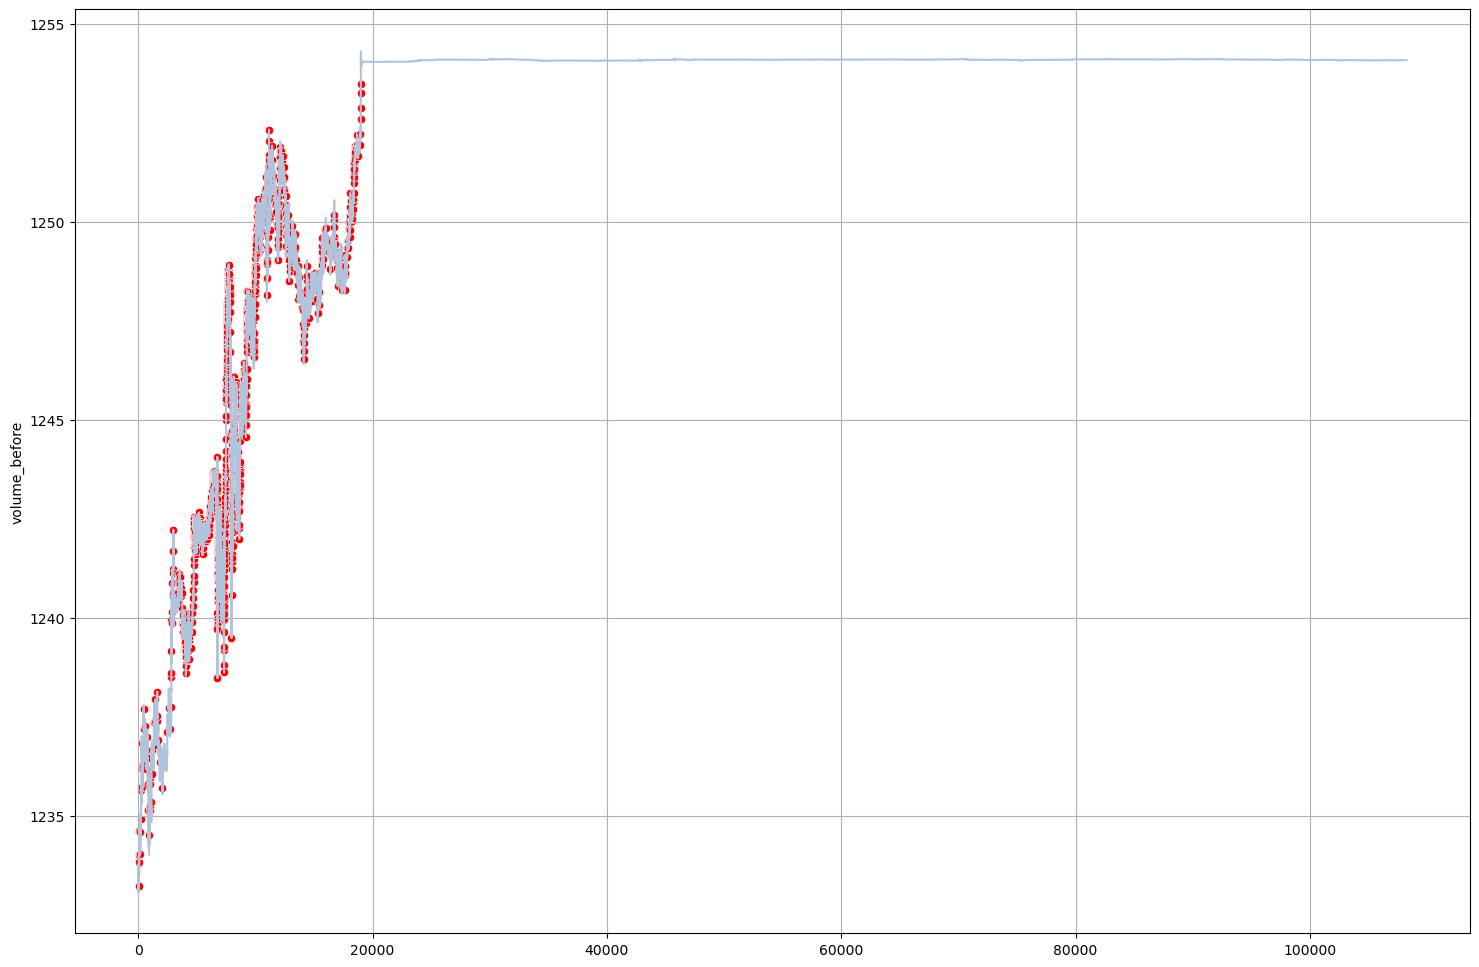

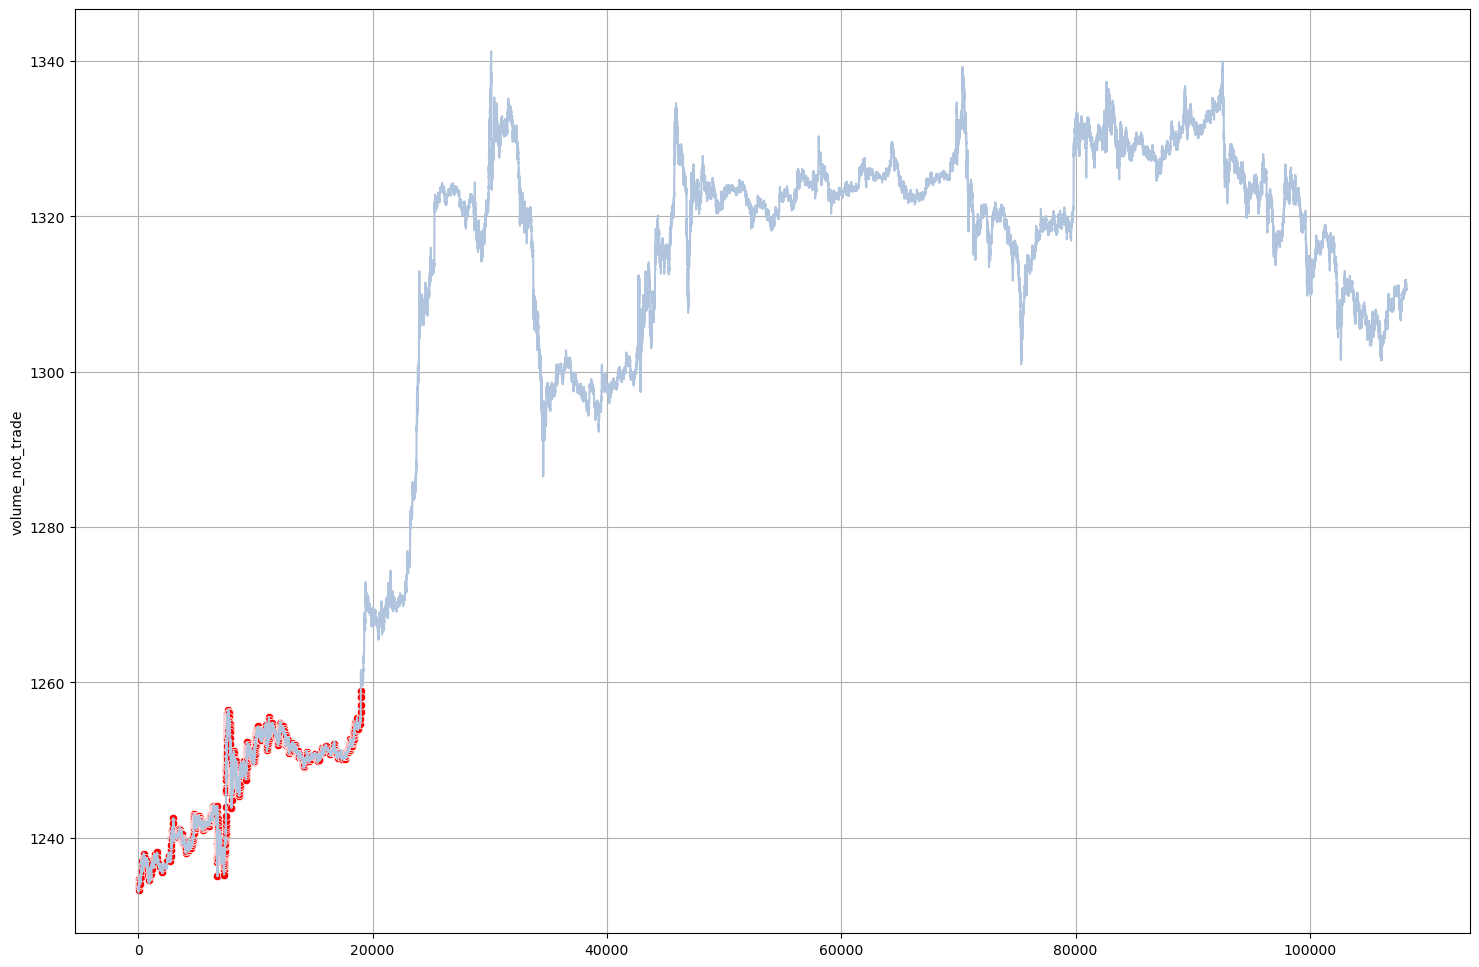

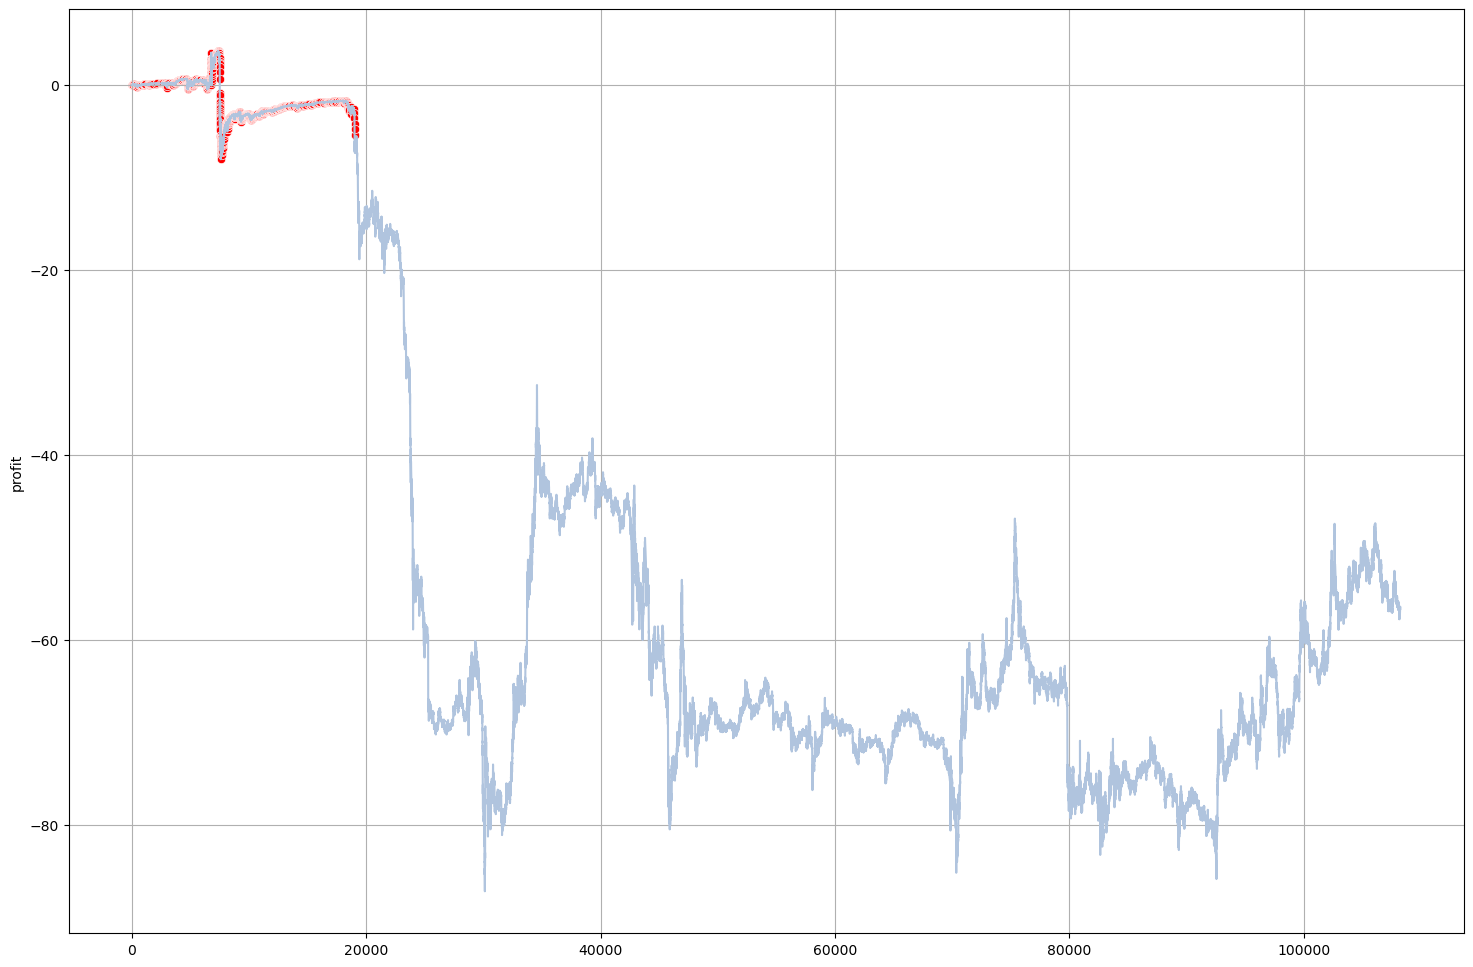

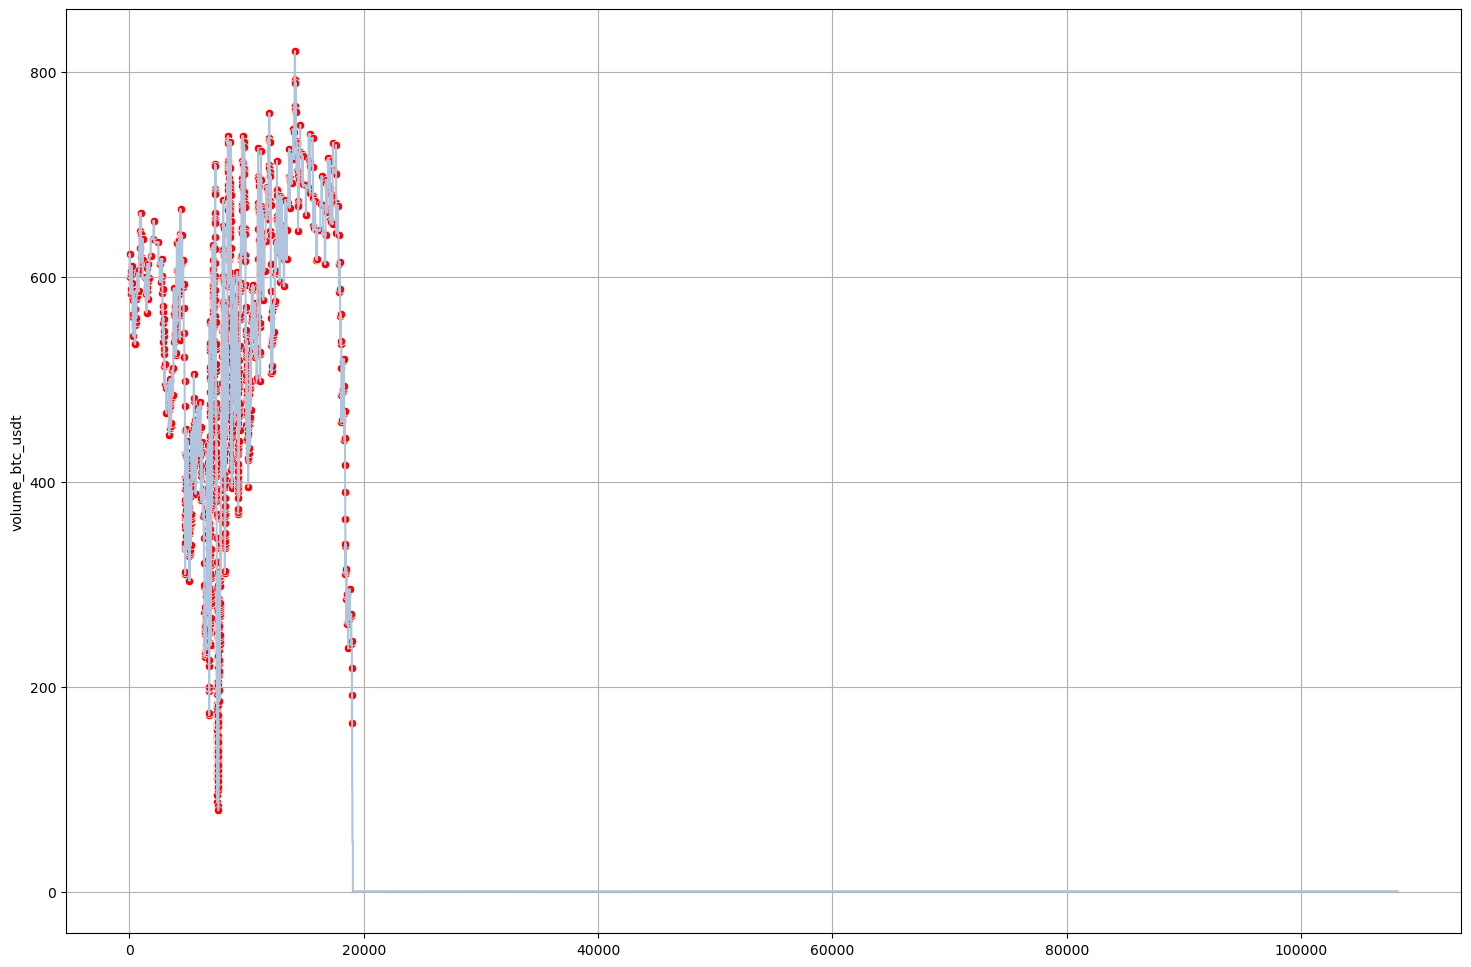

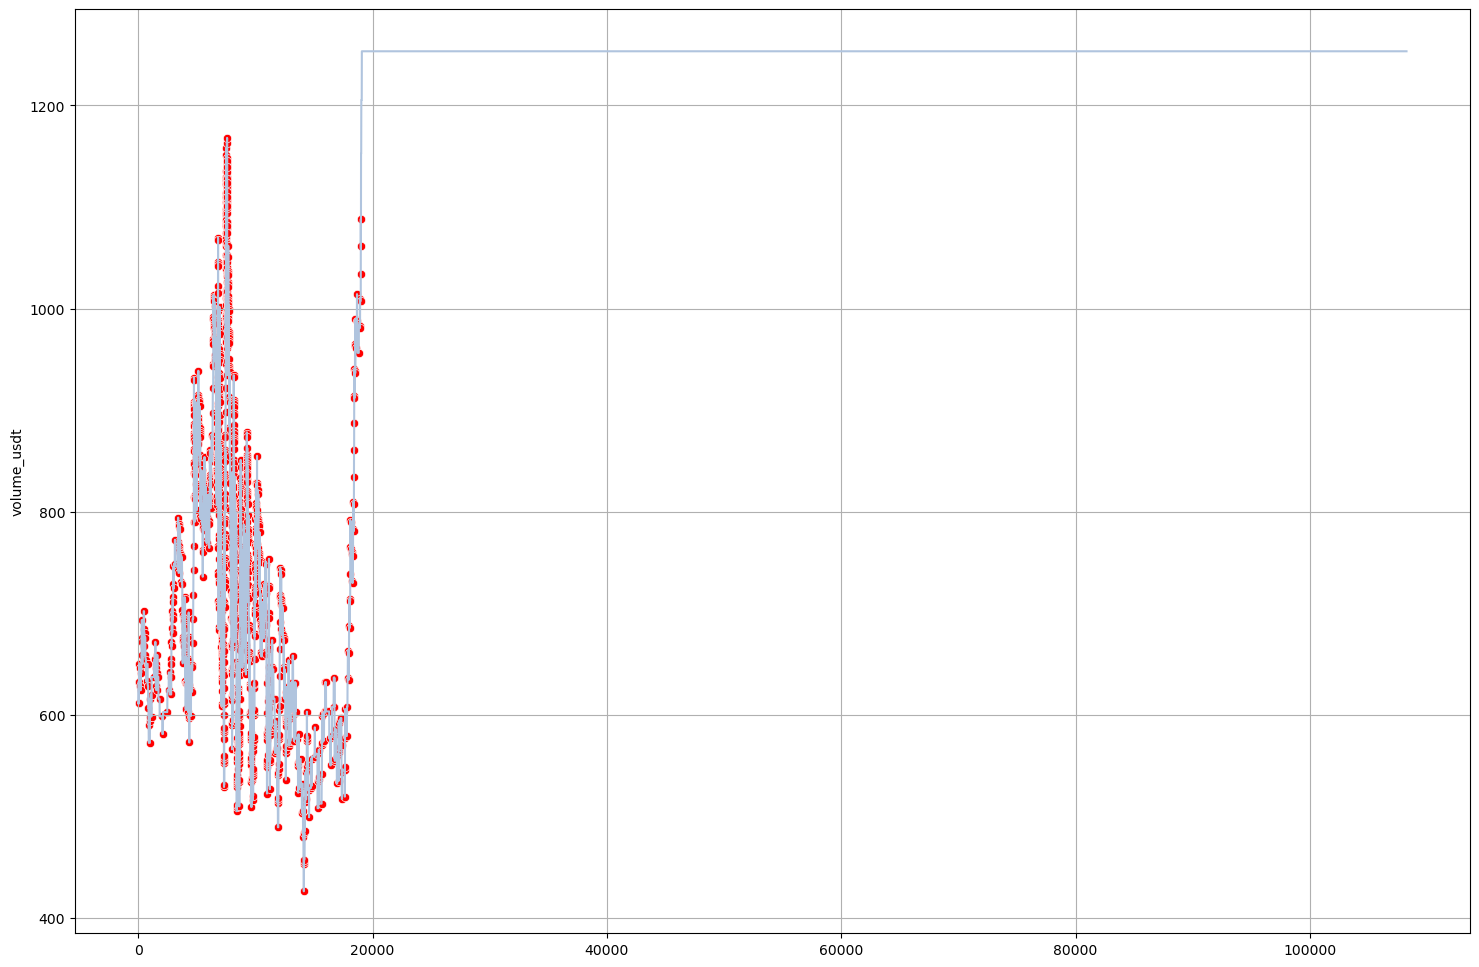

In [12]:
for y in ['volume_before', 'volume_not_trade', 'profit', 'volume_btc_usdt', 'volume_usdt']:
    plt.figure(figsize=(18, 12))
    sns.lineplot(data=trade, x=range(trade.shape[0]), y=y, color='lightsteelblue')
    y = trade['trade']*trade[y]
    y[y == 0] = np.nan
    sns.scatterplot(data=trade, x=range(trade.shape[0]), y=y, color='red')
    plt.grid(True)
    plt.show()

#### Profit Matplotlib

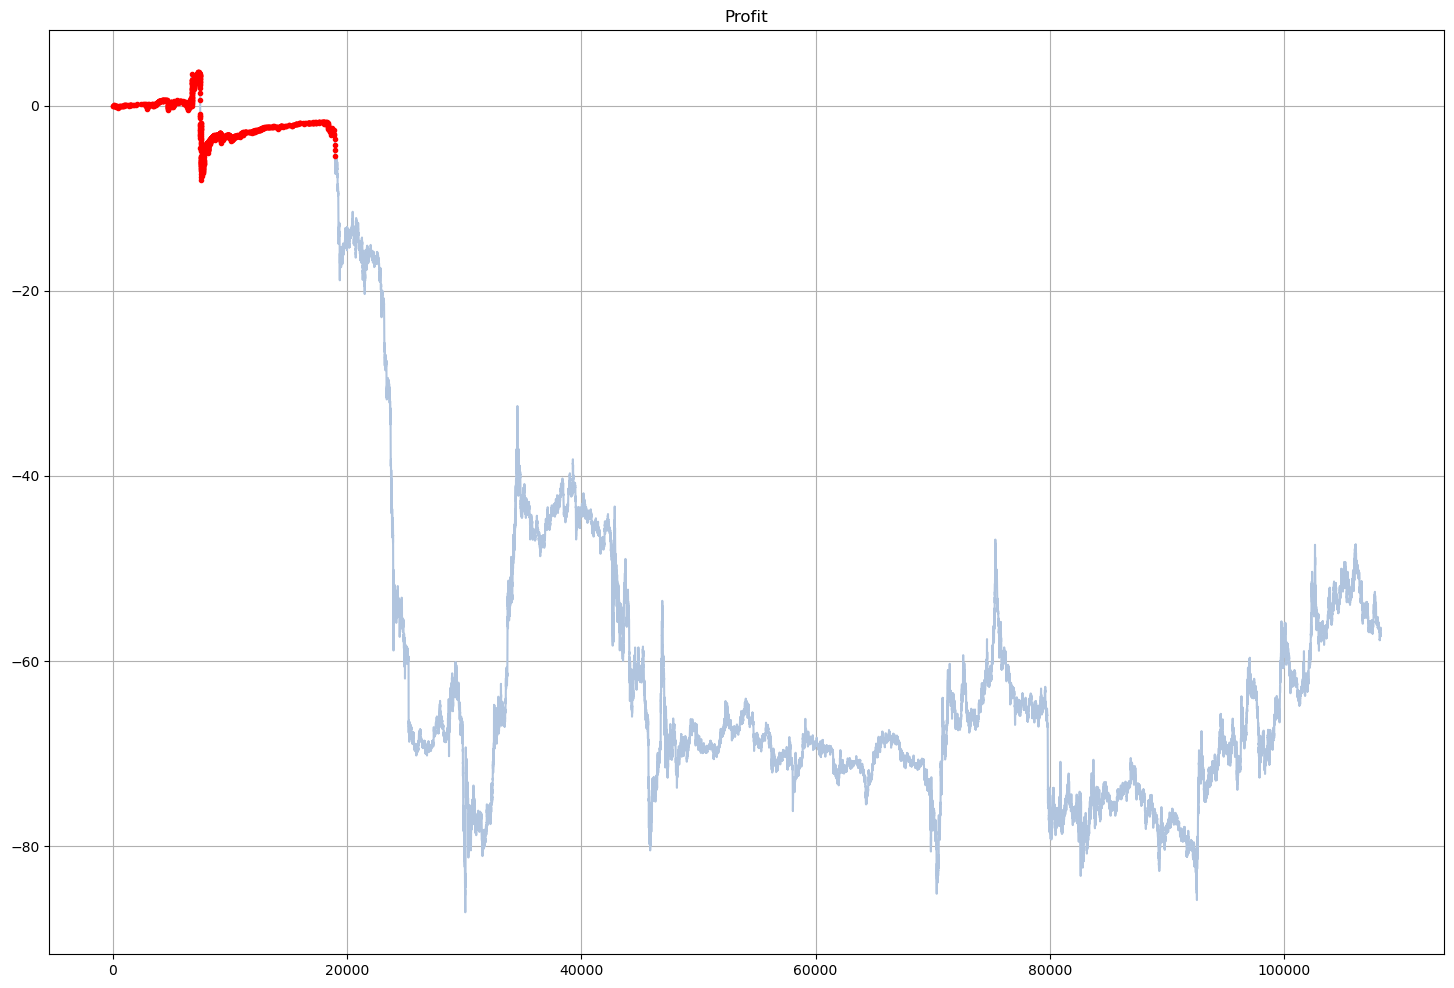

In [13]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.set_title('Profit')
plt.grid(True)
# y - trade_on_profit
y = trade['trade']*trade['profit']
y[y == 0] = np.nan

ax.plot(range(y.shape[0]),trade['profit'], color='lightsteelblue')
ax.plot(range(y.shape[0]), y, '.',color='red')

plt.show()

#### Соотношение валют Matplotlib

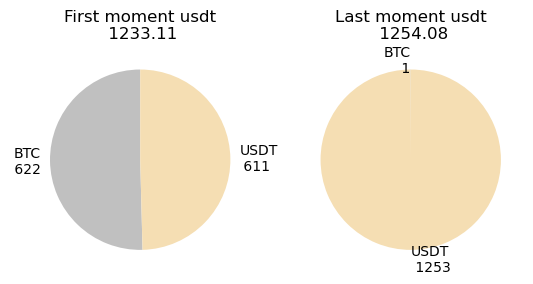

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set_title(f"First moment usdt\n {trade['volume_before'][0]:.2f}")
ax2.set_title(f"Last moment usdt\n {trade['volume_before'][-1]:.2f}")
ax1.pie((trade['volume_btc_usdt'][0],trade['volume_usdt'][0]),
        labels=(f'BTC\n {trade["volume_btc_usdt"][0]:.0f}',f'USDT\n {trade["volume_usdt"][0]:.0f}'),
        startangle=90, colors=('silver','wheat'))
ax2.pie((trade['volume_btc_usdt'][-1],trade['volume_usdt'][-1]),
        labels=(f'BTC\n {trade["volume_btc_usdt"][-1]:.0f}',f'USDT\n {trade["volume_usdt"][-1]:.0f}'),
        startangle=90, colors=('silver','wheat'))
plt.show()

#### Сделки на тренде Seaborn

#### Сделки на тренде Matplotlib

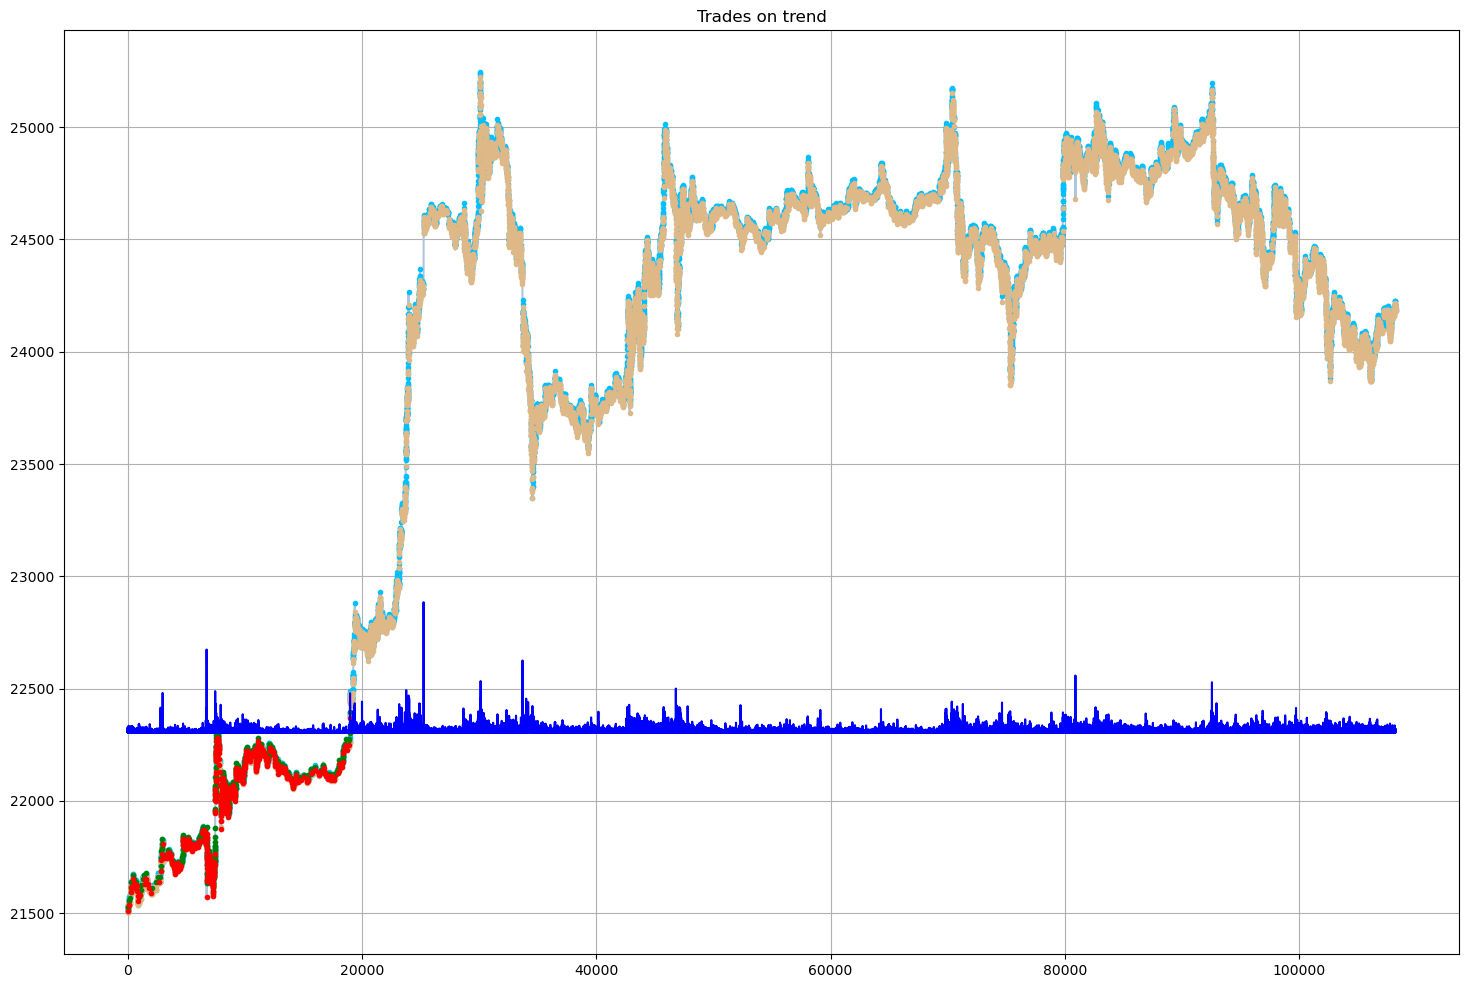

first - 21504
last - 24188


In [15]:
# first_tick = 7200
# last_tick = 8000
first_tick = 0
last_tick = trade.shape[0]
pair = 'btc_usdt'

trade['std_2'] = trade[pair].rolling(2).std()*3 + trade[pair].min() +800
trade['std_10'] = trade[pair].rolling(10).std()*-3 + trade[pair].min() +800
trade['speed_of_change'] = (trade[pair] - trade[pair].shift(periods=1))*1 + trade[pair].min() +800

    
# наложение predict
trade[pair+'_predict_min'] = trade[pair]*(trade['predict'] == 1) # заменить 0 на nan
trade[pair+'_predict_max'] = trade[pair]*(trade['predict'] == 2) # заменить 0 на nan
trade[pair+'_predict_min'].replace(0, np.nan, inplace=True)
trade[pair+'_predict_max'].replace(0, np.nan, inplace=True)
    
# наложение сделок
trade[pair+'_trade_min'] = trade['trade']*trade[pair]*(trade['predict'] == 1) # заменить 0 на nan
trade[pair+'_trade_max'] = trade['trade']*trade[pair]*(trade['predict'] == 2) # заменить 0 на nan
trade[pair+'_trade_min'].replace(0, np.nan, inplace=True)
trade[pair+'_trade_max'].replace(0, np.nan, inplace=True)
            
fig, ax = plt.subplots(figsize=(18, 12))
ax.set_title('Trades on trend')
plt.grid(True)
ax.plot(range(last_tick-first_tick), trade[pair][first_tick:last_tick], color='lightsteelblue')
ax.plot(range(last_tick-first_tick), trade[pair+'_predict_max'][first_tick:last_tick], '.',color='deepskyblue')
ax.plot(range(last_tick-first_tick), trade[pair+'_predict_min'][first_tick:last_tick], '.',color='burlywood')
ax.plot(range(last_tick-first_tick), trade[pair+'_trade_max'][first_tick:last_tick], '.',color='green')
ax.plot(range(last_tick-first_tick), trade[pair+'_trade_min'][first_tick:last_tick], '.',color='red')

ax.plot(range(last_tick-first_tick), trade['std_2'][first_tick:last_tick], color='blue')
# ax.plot(range(last_tick-first_tick), trade['std_10'][first_tick:last_tick], color='green')
# ax.plot(range(last_tick-first_tick), trade['speed_of_change'][first_tick:last_tick], color='orange')
    
plt.show()
print(f"first - {trade[pair][0]:.0f}\nlast - {trade[pair][-1]:.0f}")

#### Среднеквадратическое отклонение тренда

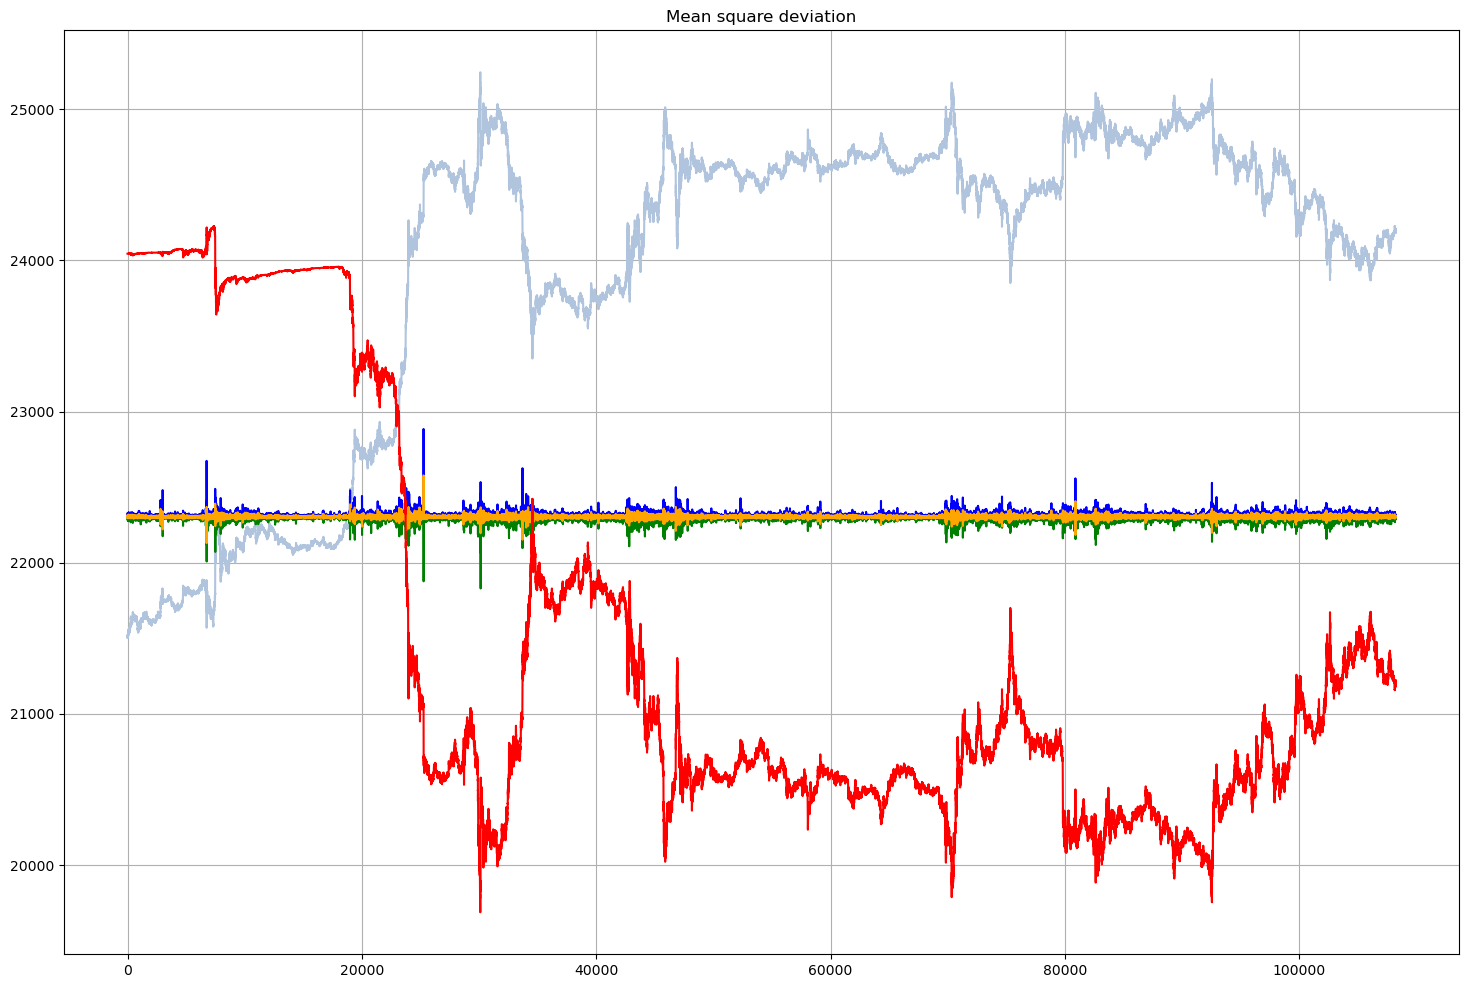

In [16]:
# first_tick = 18980
# last_tick = 19500
first_tick = 0
last_tick = trade.shape[0]
pair = 'btc_usdt'
trade['std_2'] = trade[pair].rolling(2).std()*3 + trade[pair].min() +800
trade['std_10'] = trade[pair].rolling(10).std()*-3 + trade[pair].min() +800
trade['speed_of_change'] = (trade[pair] - trade[pair].shift(periods=1))*1 + trade[pair].min() +800

fig, ax = plt.subplots(figsize=(18, 12))
ax.set_title('Mean square deviation')
plt.grid(True)
ax.plot(range(last_tick-first_tick),trade[pair][first_tick:last_tick], color='lightsteelblue')
ax.plot(range(last_tick-first_tick),trade['std_2'][first_tick:last_tick], color='blue')
ax.plot(range(last_tick-first_tick),trade['std_10'][first_tick:last_tick], color='green')
ax.plot(range(last_tick-first_tick),trade['speed_of_change'][first_tick:last_tick], color='orange')
ax.plot(range(last_tick-first_tick),(trade['profit']*50+trade[pair].max() - 1200)[first_tick:last_tick], color='red')
plt.show()